In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import torch

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import StratifiedKFold

#### Read Kaggle data

In [2]:
lincs_joined_df = pd.read_parquet("data/lincs_pretreatment.parquet")
kaggle_joined_df = pd.read_parquet("data/kaggle_pretreatment.parquet")
test_joined_df = pd.read_parquet("data/test_pretreatment.parquet")
lincs_joined_df

label                    \
                                                    SMILES cell_type control   
sig_id                                                                         
REP.A007_A375_24H:N13  CCN(CC)CCCCN1c2ccccc2Oc2ccc(Cl)cc12      A375   False   
REP.A007_A375_24H:N14  CCN(CC)CCCCN1c2ccccc2Oc2ccc(Cl)cc12      A375   False   
REP.A007_A375_24H:N15  CCN(CC)CCCCN1c2ccccc2Oc2ccc(Cl)cc12      A375   False   
REP.A007_A375_24H:N16  CCN(CC)CCCCN1c2ccccc2Oc2ccc(Cl)cc12      A375   False   
REP.A007_A375_24H:N17  CCN(CC)CCCCN1c2ccccc2Oc2ccc(Cl)cc12      A375   False   
...                                                    ...       ...     ...   
LPROT003_A549_6H:G04           O=C1c2ccccc2-c2nc3nonc3nc12      A549   False   
LPROT003_A549_6H:G06           O=C1c2ccccc2-c2nc3nonc3nc12      A549   False   
LPROT003_PC3_6H:G01            O=C1c2ccccc2-c2nc3nonc3nc12       PC3   False   
LPROT003_PC3_6H:G03            O=C1c2ccccc2-c2nc3nonc3nc12       PC3   False   
LPROT003_PC3_6H:G05            O=C1c2ccccc2-c2nc3nonc3nc12       PC3   False   

                                                     post_treatment            \
                      pert_idose  sm_name pert_itime           AARS     ABCC5   
sig_id                                                                          
REP.A007_A375_24H:N13    10.0 um  10-DEBC       24 h      -1.788735 -0.069928   
REP.A007_A375_24H:N14    3.33 um  10-DEBC       24 h      -1.464379 -0.493684   
REP.A007_A375_24H:N15    1.11 um  10-DEBC       24 h      -1.771892 -0.650293   
REP.A007_A375_24H:N16    0.37 um  10-DEBC       24 h      -1.323714 -0.968978   
REP.A007_A375_24H:N17    0.12 um  10-DEBC       24 h      -1.329854 -0.905254   
...                          ...      ...        ...            ...       ...   
LPROT003_A549_6H:G04     10.0 um   smer-3        6 h      -0.277300  0.176900   
LPROT003_A549_6H:G06     10.0 um   smer-3        6 h      -1.381100  0.055000   
LPROT003_PC3_6H:G01      10.0 um   smer-3        6 h      -0.575300  1.264400   
LPROT003_PC3_6H:G03      10.0 um   smer-3        6 h       0.217800 -0.147700   
LPROT003_PC3_6H:G05      10.0 um   smer-3        6 h       0.687200 -0.027800   

                                           ... pre_treatment            \
                          ABCF1     ABCF3  ...         ZMIZ1     ZMYM2   
sig_id                                     ...                           
REP.A007_A375_24H:N13 -0.280553 -0.554839  ...      0.285836  0.276084   
REP.A007_A375_24H:N14 -0.360274 -1.566500  ...      0.285836  0.276084   
REP.A007_A375_24H:N15 -0.240555  0.205145  ...      0.285836  0.276084   
REP.A007_A375_24H:N16 -0.254031 -0.398962  ...      0.285836  0.276084   
REP.A007_A375_24H:N17 -1.020507 -0.048905  ...      0.285836  0.276084   
...                         ...       ...  ...           ...       ...   
LPROT003_A549_6H:G04  -0.456600  0.051100  ...      0.007782  0.186617   
LPROT003_A549_6H:G06  -0.260800 -0.959900  ...      0.007782  0.186617   
LPROT003_PC3_6H:G01    2.421300  0.250900  ...     -0.056932  0.125911   
LPROT003_PC3_6H:G03   -2.118000  0.250900  ...     -0.056932  0.125911   
LPROT003_PC3_6H:G05   -1.575300  0.594900  ...     -0.056932  0.125911   

                                                                         \
                         ZNF131    ZNF274    ZNF318    ZNF395    ZNF451   
sig_id                                                                    
REP.A007_A375_24H:N13  0.351392  0.036401  0.205662 -0.198529  0.052772   
REP.A007_A375_24H:N14  0.351392  0.036401  0.205662 -0.198529  0.052772   
REP.A007_A375_24H:N15  0.351392  0.036401  0.205662 -0.198529  0.052772   
REP.A007_A375_24H:N16  0.351392  0.036401  0.205662 -0.198529  0.052772   
REP.A007_A375_24H:N17  0.351392  0.036401  0.205662 -0.198529  0.052772   
...                         ...       ...       ...       ...       ...   
LPROT003_A549_6H:G04   0.223691 -0.033883 -0.124051 -0.191101 -0.238230   
LPROT003_A

In [3]:
lincs_cells = lincs_joined_df.reset_index()["label"]["cell_type"].unique()
kaggle_cells = kaggle_joined_df.reset_index()["label"]["cell_type"].unique()
all_cells = np.union1d(lincs_cells,kaggle_cells)
len(all_cells)

36

In [4]:
lincs_smiles = lincs_joined_df.reset_index()["label"]["sm_name"].unique()
kaggle_smiles = kaggle_joined_df.reset_index()["label"]["sm_name"].unique()
all_smiles = np.union1d(lincs_smiles,kaggle_smiles)
len(all_smiles)

1896

In [5]:
smile_map = lincs_joined_df["label"][["sm_name","SMILES"]].set_index("sm_name").to_dict()["SMILES"]
len(smile_map)

1768

### Prepare train data for folds

In [6]:
B_M_df = kaggle_joined_df[kaggle_joined_df["label"]["cell_type"].isin(["B cells", "Myeloid cells"])].reset_index(drop=True)
mean_score = pd.concat([B_M_df["label"]["sm_name"],B_M_df["post_treatment"]],axis=1).groupby("sm_name").agg("mean").mean(axis=1)
classes = np.digitize(mean_score.values, bins=[0.1, 0.5, 1])
cpds = mean_score.index.values
fold_arr = np.full(len(cpds), -1)
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for fold, (trn_ind, val_ind) in enumerate(skf.split(classes, classes)):
    fold_arr[val_ind] = fold
fold_map = {c: f for c, f in zip(cpds, fold_arr)}
fold_to_cpds = {fold: cpds[fold_arr==fold] for fold in range(3)}

fold_to_cpds

/Users/laurasisson/miniconda3/envs/rdenv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


{0: array(['Alvocidib', 'Foretinib', 'Linagliptin',
        'O-Demethylated Adapalene', 'R428'], dtype=object),
 1: array(['CHIR-99021', 'Crizotinib', 'LDN 193189', 'MLN 2238',
        'Penfluridol'], dtype=object),
 2: array(['Dactolisib', 'Idelalisib', 'Oprozomib (ONX 0912)', 'Palbociclib',
        'Porcn Inhibitor III'], dtype=object)}

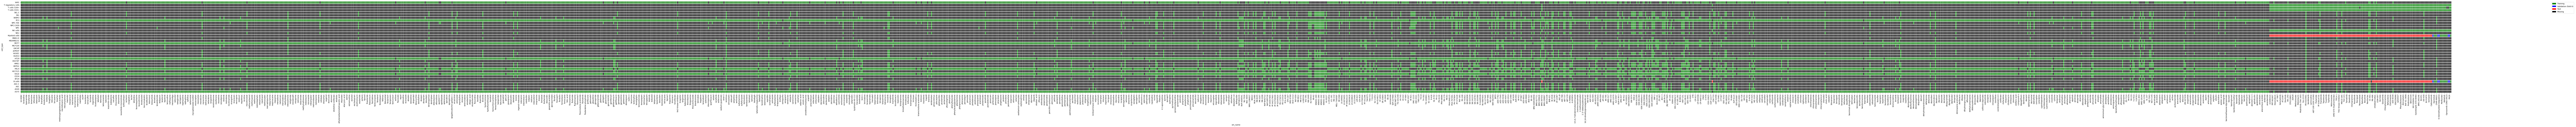

In [7]:
def plot_cv_diagram(fold, fold_to_cpds):
    cv_diagram = pd.concat([df["label"][['cell_type', 'sm_name']] for df in [lincs_joined_df,kaggle_joined_df,test_joined_df]], axis=0, keys=[2,2,1])
    cv_diagram = cv_diagram.reset_index().drop(columns=['level_1'])
    
    # LINCS data contains multiple measurements for (cell_type,sm_name) differentiated by dose, and time
    # Drop those here
    cv_diagram = cv_diagram.drop_duplicates()
    cv_diagram = cv_diagram.pivot(index='cell_type', columns='sm_name')
    cv_diagram.fillna(0, inplace=True)
    cv_diagram = cv_diagram.droplevel(level=0, axis=1)
    cv_diagram = cv_diagram.sort_values('Myeloid cells', axis=1)
    cv_diagram = cv_diagram.sort_index(ascending=False)
#     cv_diagram.loc[val_cell_type] *= 1 + (cv_diagram.loc[['Myeloid cells', 'B cells']] == 1).any().astype(float) * 0.5
    cpds_fold = fold_to_cpds[fold].tolist()
    cv_diagram.loc[['Myeloid cells', 'B cells'], cpds_fold] = 3
    # 0=Missing
    # 1=Test
    # 2=Training
    # 3=Validation
    fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=(20, 1), figsize=(200, 10))
    sns.heatmap(cv_diagram, cbar=False, linewidths=1, ax=ax1, cmap=['k', 'r', 'g', 'b'])
    
    ax2.legend(handles=[mpatches.Patch(color='g', label='Training'),
                        mpatches.Patch(color='b', label=f'Validation (fold {fold})'),
                        mpatches.Patch(color='r', label='Test'),
                        mpatches.Patch(color='k', label='Missing')])
    ax2.axis('off')
    fig.tight_layout()
    plt.show()

# Girls when they make a beautiful diagram
plot_cv_diagram(0, fold_to_cpds)

#### Merge all available training data

In [8]:
all_train_df = pd.concat([kaggle_joined_df,lincs_joined_df])

Our model is simple:
- We use the reduced, shared set of genes as the targets
- We use sm_name as our unique feature, one-hot encode it and then use ridge regression to predict the transformed targets.
- We then predict the full set of genes from the shared genes.
- The two hyperparameters `n_components` and `alpha` were tuned for the best cross-validation score.

In [9]:
temp = kaggle_joined_df.groupby(("label","cell_type")).size() > 20
validation_cell_types = temp[temp].index # 4 cell types
train_sm_names = kaggle_joined_df["label"].query("cell_type == 'B cells'").sm_name.values # 17 compounds including the two control compounds
features = ['cell_type', 'sm_name']
multiindex_features = [("label",'cell_type'),("label",'sm_name')]

#### Build landmark prediction model

In [10]:
def cross_val_svd(landmark_model, label, n_components, print_each=False):
    mrrmse_list = []
    for fold in range(3):
#         mask_va = (de_train.cell_type == val_cell_type) & ~de_train.sm_name.isin(train_sm_names)
        mask_va = all_train_df[("label",'cell_type')].isin(['Myeloid cells', 'B cells']) & all_train_df[("label",'sm_name')].isin(fold_to_cpds[fold])
        mask_tr = ~mask_va # 485 or 487 training rows
        
        train = all_train_df[mask_tr]
        val = all_train_df[mask_va]
        y_true = val["post_treatment"]

        # Although we are predicting a subset of genes, we will still decompose.
        svd = TruncatedSVD(n_components=n_components, random_state=1)
        z_tr = svd.fit_transform(train["post_treatment"])
        
        landmark_model.fit(train["label"][features], z_tr)
        y_pred = svd.inverse_transform(landmark_model.predict(val["label"][features]))
        
        mrrmse = np.sqrt(np.square(y_true - y_pred).mean(axis=1)).mean()
        if print_each:
#             print(f"# Fold {fold}: {mrrmse:5.3f} val='{val_cell_type}'")
            print(f"# Fold {fold}: {mrrmse:5.3f}")
        mrrmse_list.append(mrrmse)
    mrrmse = np.array(mrrmse_list).mean()
    print(f"# Overall {mrrmse:5.3f} {label}")
    return mrrmse

n_components = 30
alpha = 5
landmark_model = make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(), ['sm_name'])]),
                      Ridge(alpha=alpha, fit_intercept=False))

cross_val_svd(landmark_model, f'svd {n_components=} ridge {alpha=}',
              n_components=n_components, print_each=True)

# Fold 0: 1.965
# Fold 1: 2.002
# Fold 2: 2.090
# Overall 2.019 svd n_components=30 ridge alpha=5


2.0188050116572005

Train with all training data, from best hparams

In [12]:
svd = TruncatedSVD(n_components=n_components, random_state=1)
z_tr = svd.fit_transform(all_train_df["post_treatment"])
landmark_model.fit(all_train_df["label"][features], z_tr)
y_pred = svd.inverse_transform(landmark_model.predict(test_joined_df["label"][features]))
y_pred.shape

(255, 918)

#### Build landmark -> transcriptome prediction model
Read transcriptome data from Kaggle provided dataset

In [13]:
de_train = pd.read_parquet('data/de_train.parquet')
genes = de_train.columns[5:] # 18211 genes
de_train = de_train.query("~control").sort_values(features)
kaggle_joined_df = kaggle_joined_df.sort_values(multiindex_features)
transcriptome_cols = de_train.columns[5:]

# Lets make sure the dataframes are lined up correctly.
landmark_cols = kaggle_joined_df["post_treatment"].columns
(kaggle_joined_df["post_treatment"] == de_train[landmark_cols]).all(axis=None)

True

In [23]:
def cross_val_transcriptome(trained_landmark_model, trained_svd, transcriptome_model, label, print_each=False):
    def make_x(masked_joined_df):
        decomposed = trained_landmark_model.predict(masked_joined_df["label"][features])
        assert decomposed.shape[1] == n_components
        lms = trained_svd.inverse_transform(decomposed)
        assert lms.shape[1] == len(landmark_cols)
        return lms
        
    mrrmse_list = []
    for fold in range(3):
#         mask_va = (de_train.cell_type == val_cell_type) & ~de_train.sm_name.isin(train_sm_names)
        mask_va = kaggle_joined_df[("label",'cell_type')].isin(['Myeloid cells', 'B cells']) & kaggle_joined_df[("label",'sm_name')].isin(fold_to_cpds[fold])
        mask_tr = ~mask_va # 485 or 487 training rows
        assert mask_va.shape[0] == de_train.shape[0]

        train_x = make_x(kaggle_joined_df[mask_tr])
        train_y = de_train[mask_tr][transcriptome_cols]
        
        val_x = make_x(kaggle_joined_df[mask_va])
        val_y = de_train[mask_va][transcriptome_cols]
        
        transcriptome_model.fit(train_x, train_y)
        val_pred_y = transcriptome_model.predict(val_x)
        
        mrrmse = np.sqrt(np.square(val_y - val_pred_y).mean(axis=1)).mean()
        if print_each:
#             print(f"# Fold {fold}: {mrrmse:5.3f} val='{val_cell_type}'")
            print(f"# Fold {fold}: {mrrmse:5.3f}")
        mrrmse_list.append(mrrmse)
    mrrmse = np.array(mrrmse_list).mean()
    print(f"# Overall {mrrmse:5.3f} {label}")
    return mrrmse

transcriptome_model = Ridge(alpha=alpha, fit_intercept=False)
cross_val_transcriptome(landmark_model, svd, transcriptome_model, "transcriptome",print_each=True)


# Fold 0: 1.873
# Fold 1: 2.534
# Fold 2: 1.991
# Overall 2.133 transcriptome


2.132590870386226

Train with all training data, from best hparams

In [30]:
train_x = svd.inverse_transform(landmark_model.predict(kaggle_joined_df["label"][features]))
assert train_x.shape == kaggle_joined_df["post_treatment"].shape
transcriptome_model.fit(train_x,de_train[transcriptome_cols])

(255, 18211)

# Submission

Predict full pipeline for test and create a submission file.

In [58]:
id_map = pd.read_csv('data/id_map.csv',
                     index_col='id')
# Quick sanity check to make sure our submission is ordered correctly.
assert (test_joined_df["label"][features] == id_map[features]).all(axis=None)


# Full pipeline. Nice
y_pred = transcriptome_model.predict(
    svd.inverse_transform(
        landmark_model.predict(test_joined_df["label"][features])))

y_pred.shape
submission = pd.DataFrame(y_pred, columns=genes, index=id_map.index)
display(submission)
submission.to_csv('submissions/pipeline.csv')

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
id,,,,,,,,,,,,,,,,,,,,,
0,0.294481,0.230702,0.425344,0.559257,1.001134,0.887338,-0.091047,0.611727,-0.420787,0.587404,...,-0.281824,-0.131179,0.320061,0.078107,0.553654,0.458492,0.115852,0.209186,-0.351442,0.286467
1,0.177224,0.044748,-0.019433,0.153962,0.445023,0.264313,-0.049020,-0.070047,-0.112487,-0.028467,...,-0.119114,-0.017036,-0.174181,0.094107,0.123673,0.031947,0.047107,0.026204,-0.006375,-0.168053
2,0.486619,0.445924,0.281815,0.316360,0.691532,1.365807,0.083608,0.490243,0.013280,-0.204951,...,-0.036272,0.178165,0.263243,0.398788,0.510641,0.395321,0.298725,0.241701,-0.292496,-0.255551
3,-0.007276,0.059329,0.105082,0.183107,0.169563,-0.028068,0.020929,0.168860,-0.054674,0.041065,...,-0.025952,0.030291,-0.023400,0.104293,0.183704,0.070051,0.094985,0.091575,-0.125007,-0.093906
4,0.003565,0.089501,0.027734,0.030284,0.026301,0.242934,0.008946,0.186249,-0.160717,0.286452,...,-0.157279,0.005209,-0.000597,-0.112590,0.168707,0.177725,0.073628,0.108304,-0.200084,0.065492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,-0.204143,-0.114184,-0.099702,0.107506,-0.168730,-0.981150,-0.071481,-0.162179,-0.193771,0.195512,...,-0.085138,-0.157506,-0.244056,-0.237594,-0.194088,-0.098549,-0.010339,-0.047314,0.086338,-0.048383
251,0.175512,-0.057072,0.130784,0.251049,0.511176,0.159908,-0.071782,-0.094552,-0.104119,0.549339,...,-0.031385,-0.093118,-0.008448,-0.076147,0.015546,-0.065220,0.040608,0.016593,0.005989,-0.009914
252,-0.095513,0.029040,-0.010390,0.074600,-0.063168,-0.333096,-0.024355,-0.035811,-0.038285,0.184321,...,0.014049,-0.077455,-0.046697,-0.033374,-0.004667,0.024774,0.001785,0.003715,-0.050377,0.053018
